In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pylab as pl
import pandas as pd
import os
from IPython.core.display import HTML

import matplotlib.mlab as mlab
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
#from plotly.graph_objs import Scatter, Figure, Layout
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
x = pd.read_excel("zap_resultado1400_2017-05-29.xlsx")

In [3]:
x.head(5)

,link,preco,bairro,endereco,quartos,area,suites,vagas,descricao
1,https://www.zapimoveis.com.br/lancamento/apart...,Sob consulta,Botafogo,Rua Real Grandeza •\r\n ...,2 a 3 quartos,66 a 97m2,1 suíte,1 a 2 vagas,Apartamento na Planta\r\n Sofis...
2,https://www.zapimoveis.com.br/lancamento/apart...,R$ 1.380.000,Botafogo,Rua Sorocaba •\r\n ...,2 a 3 quartos,93 a 110m2,1 suíte,1 a 2 vagas,Apartamento Pronto Para Morar\r\n ...
3,https://www.zapimoveis.com.br/lancamento/apart...,R$ 1.380.000,Botafogo,Rua Pinheiro Guimarães •\r\n ...,2 a 4 quartos,105 a 131m2,1 a 2 suítes,1 a 3 vagas,Apartamento Pronto Para Morar\r\n ...
4,https://www.zapimoveis.com.br/superdestaque/ve...,R$ 1.350.000,Copacabana,Rua Marechal Mascarenhas de Mo...,2 quartos,85m2,1 suíte,2 vagas,Apartamento\r\n Prédio excelent...
5,https://www.zapimoveis.com.br/superdestaque/ve...,R$ 3.500.000,Leblon,Rua General Venâncio Flores •\...,3 quartos,125m2,1 suíte,1 vaga,"Apartamento\r\n Alto padrão, to..."


In [4]:
# Vamos ver quantos tem vaga e quantos tem suites e quartos
df = x.copy()
("Numero de apts que possuem valores não nulos pra cada coluna")
df.count()

link         35000
preco        35000
bairro       35000
endereco     35000
quartos      33600
area         35000
suites       14788
vagas        15368
descricao    35000
dtype: int64

In [5]:
#Substituo os NaN nas suites e vagas por "0"

df.suites = df.suites.fillna("0")
df.vagas = df.vagas.fillna("0")

#Tiro os apts que não tem quartos (podem ser apenas vagas sendo vendidas, em vez de apartamentos inteiros)

df = df.dropna(subset=["quartos"]) 

#Eliminar o "m2" do final do valor das areas

df['area'] = df['area'].map(lambda x: x.replace("m2",""))

#Eliminar o "vagas" ao final das vagas


df.vagas = df.vagas.str.rstrip("vagas")

# Tiro as entradas que tem preço "Sob consulta"

df = df[df.preco.str.contains("Sob consulta") == False]

# Tirar "R$" da frente do valor do preço e os pontos e transformar coluna para inteiro

df['preco'] = df['preco'].replace('[\R$]','',regex=True)
df['preco'] = df['preco'].replace('[\.]','',regex=True).astype(float)

df.quartos.value_counts()

1 quarto         12840
2 quartos         9598
3 quartos         6828
4 quartos          707
2 a 3 quartos      600
2 a 4 quartos      589
5 quartos           28
Name: quartos, dtype: int64

In [6]:
#Tomar apenas o primeiro valor dos quartos, já que sempre o anunciado para mais de um apt é "A partir de X reais"
#Supõe-se que o preço do imóvel divulgado é para o valor mínimo de quartos anunciado. O mesmo pra suítes, vagas e área.

df["quartos"] = df["quartos"].map((lambda x: x[0])).astype(int)
df["suites"] = df["suites"].map((lambda x: x[0])).astype(int)
df["vagas"] = df["vagas"].map((lambda x: x[0])).astype(int)
df["area"] = df["area"].map((lambda x: x.split(' ', 1)[0])).astype(int)

# Tomar endereco apenas como o nome da rua
df["endereco"] = df["endereco"].map(lambda x: x.split('•', 1)[0].rstrip().lstrip()) # split() only once

#Defino uma nova coluna chamada "preço_m2", que será o preço/metro quadrado
df["preco_m2"] = df.preco/df.area

df.quartos.value_counts()

1    12840
2    10787
3     6828
4      707
5       28
Name: quartos, dtype: int64

In [7]:
df = df.reset_index()
df.to_excel("zap_resultado_limpo.xlsx")

In [8]:
data = pd.read_excel("zap_resultado_limpo.xlsx")

- Quais as principais diferenças entre os apartamentos de cada bairro da Zona Sul do Rio de Janeiro?
- Quais os bairros com os aluguéis mais caros?
- Quantos quartos os apartamentos têm em média?
- A oferta de apartamentos de um bairro influencia o preço médio do aluguel?


# Análise Geral

## Valor de venda

Qual o valor de 1 vaga? e 1 quarto?
Qual o bairro com melhor média Preço/m2?

In [ ]:
azul = "#01a2d9" # definir cor para usar nos gráficos


In [9]:
def bstats(vec):
    s = {'num_element':len(vec), 'minimo':vec.min(),
         'maximo':vec.max(), 'media':vec.mean(),
         'desvio_padrao':vec.std()}
    return s

In [10]:
# Estatísticas do Preço
bstats(data.iloc[:,2])


{'desvio_padrao': 1668828.5754322903,
 'maximo': 14000000,
 'media': 1407323.436870792,
 'minimo': 360000,
 'num_element': 31190}

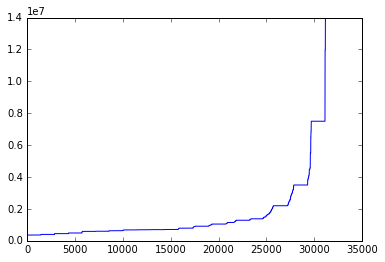

In [11]:
plt.plot(sorted(data.iloc[:,2]))
plt.show()

### Análise --POR QUARTOS--

In [12]:
quartos_stats = data.groupby('quartos')[['preco','area','suites','vagas', 'preco_m2']].describe()

quartos_stats


preco                                                               \
           count          mean           std        min        25%        50%   
quartos                                                                         
1        12840.0  6.928961e+05  2.442540e+05   360000.0   600000.0   680000.0   
2        10787.0  9.703367e+05  6.242994e+05   400000.0   450000.0   690000.0   
3         6828.0  3.188132e+06  2.511257e+06   740000.0  1070000.0  2200000.0   
4          707.0  3.696808e+06  2.492360e+06  1200000.0  1900000.0  2900000.0   
5           28.0  5.300000e+06  1.422049e+06  4000000.0  4000000.0  4000000.0   

                                   area                  ...      vagas       \
               75%         max    count        mean      ...        75%  max   
quartos                                                  ...                   
1         710000.0   1500000.0  12840.0   51.677259      ...        0.0  1.0   
2        1380000.0   4600000.0  10787.0   84.649300      ...        1.0  3.0   
3        3500000.0  14000000.0   6828.0  149.744435      ...        2.0  3.0   
4        4490000.0  14000000.0    707.0  208.978784      ...        3.0  4.0   
5        6800000.0   6800000.0     28.0  345.142857      ...        4.0  4.0   

        preco_m2                                                         \
           count          mean          std           min           25%   
quartos                                                                   
1        12840.0  13218.648481  2970.541524   7307.692308  10888.888889   
2        10787.0  10603.656156  3613.043220   6666.666667   7500.000000   
3         6828.0  19005.090911  9447.699593   7400.000000   9208.471599   
4          707.0  17702.070120  9222.604923   5642.633229   9882.347059   
5           28.0  15577.816492  4886.055490  11111.111111  11111.111111   

                                                   
                  50%           75%           max  
quartos                                            
1        12950.819672  14166.666667  18970.588235  
2         8625.000000  13142.857143  40000.000000  
3        17322.834646  21875.000000  42857.142857  
4        16818.181818  21000.000000  41176.470588  
5        11111.111111  20731.707317  20731.707317  

[5 rows x 40 columns]

### Printa, para número de quarto oferecidos, o valor do preço do imóvel/quantidade de anúncios com esse preço 
#### Preços ordenados do menor para o maior

In [13]:
print_full(data.groupby('quartos').preco.value_counts().sort_index())

NameError: name 'print_full' is not defined

### Análise de Preço/Número de ofertas para aquele preço --POR BAIRRO--

In [14]:
#Crio uma nova dataframe chamada bairros_stats onde coloco meu describe por bairro


bairros_stats = data.groupby('bairro')[['preco','area','suites','vagas','quartos', 'preco_m2']].describe()


bairros_stats  
#display(HTML(bairros_stats.to_html()))  #option used to display entire dataframe (not truncated)




#Ex de pesquisa na dataframe: 
#bairros_stats.loc['Botafogo']

preco                                                    \
                   count          mean           std        min        25%   
bairro                                                                       
Botafogo          5052.0  9.215439e+05  5.276575e+05   490000.0   490000.0   
Catete              94.0  9.107553e+05  2.395117e+05   430000.0   649000.0   
Copacabana       12202.0  7.859319e+05  3.593783e+05   360000.0   680000.0   
Flamengo           443.0  1.687111e+06  1.007555e+06   528000.0   950000.0   
Glória            1450.0  5.894345e+05  4.181309e+04   400000.0   590000.0   
Gávea             1477.0  2.192640e+06  6.464256e+04  1790000.0  2200000.0   
Humaitá            178.0  1.158483e+06  4.374521e+05   720000.0   880000.0   
Ipanema            712.0  3.274702e+06  2.864701e+06   650000.0  1550000.0   
Jardim Botânico   1572.0  3.370880e+06  6.592888e+05   695000.0  3500000.0   
Lagoa             1613.0  6.925270e+06  1.619130e+06  1350000.0  7500000.0   
Laranjeiras        131.0  9.604198e+05  3.262774e+05   475000.0   890000.0   
Leblon            1965.0  1.710036e+06  1.297904e+06   850000.0  1290000.0   
Leme              1450.0  6.546414e+05  1.444025e+05   630000.0   630000.0   
Santa Teresa      2800.0  4.250000e+05  2.500447e+04   400000.0   400000.0   
Urca                51.0  1.766255e+06  8.810703e+05  1149000.0  1149000.0   

                                                      area              \
                       50%        75%         max    count        mean   
bairro                                                                   
Botafogo          690000.0  1380000.0   6800000.0   5052.0   77.168250   
Catete            998000.0  1080000.0   1150000.0     94.0   75.180851   
Copacabana        710000.0   915000.0   4490000.0  12202.0   68.523275   
Flamengo         1600000.0  2000000.0   4500000.0    443.0  159.006772   
Glória            590000.0   590000.0    900000.0   1450.0   69.883448   
Gávea            2200000.0  2200000.0   2500000.0   1477.0  141.377793   
Humaitá          1050000.0  1350000.0   2430000.0    178.0   84.533708   
Ipanema          2749000.0  3850000.0  14000000.0    712.0  146.470506   
Jardim Botânico  3500000.0  3500000.0   6500000.0   1572.0  155.956743   
Lagoa            7500000.0  7500000.0   7500000.0   1613.0  211.130192   
Laranjeiras       950000.0  1000000.0   1900000.0    131.0   97.297710   
Leblon           1290000.0  1460000.0  11900000.0   1965.0   82.728244   
Leme              630000.0   630000.0   1830000.0   1450.0   61.283448   
Santa Teresa      425000.0   450000.0    450000.0   2800.0   60.000000   
Urca             1150000.0  3000000.0   3000000.0     51.0  111.137255   

                     ...      quartos      preco_m2                \
                     ...          75%  max    count          mean   
bairro               ...                                            
Botafogo             ...          2.0  5.0   5052.0  11604.109863   
Catete               ...          3.0  3.0     94.0  11988.484043   
Copacabana           ...          2.0  4.0  12202.0  12184.722428   
Flamengo             ...          3.0  5.0    443.0  11000.823287   
Glória               ...          2.0  3.0   1450.0   8457.895791   
Gávea                ...          2.0  4.0   1477.0  15520.514161   
Humaitá              ...          3.0  3.0    178.0  13516.309620   
Ipanema              ...          3.0  4.0    712.0  20275.951299   
Jardim Botânico      ...          3.0  4.0   1572.0  21374.116048   
Lagoa                ...          3.0  4.0   1613.0  32196.847842   
Laranjeiras          ...          3.0  3.0    131.0   9898.770943   
Leblon               ...          2.0  4.0   1965.0  19668.379525   
Leme                 ...          1.0  3.0   1450.0  10621.278294   
Santa Teresa         ...          2.0  2.0   2800.0   7083.333333   
Urca                 ...          3.0  3.0     51.0  15335.567658   

                                      

In [15]:
#funçao pra printar todo o value counts (sem truncar)
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
    
print_full(data.groupby('bairro').preco.value_counts())

bairro           preco   
Botafogo         690000      1409
                 490000      1400
                 1380000     1206
                 1150000      617
                 650000        31
                 800000        28
                 970000        27
                 1000000       26
                 685000        21
                 1850000       21
                 750000        20
                 1450000       18
                 1300000       17
                 1600000       17
                 1250000       16
                 1400000       16
                 1655000       15
                 3150000       15
                 1080000       14
                 1190000       14
                 1360000       14
                 660000        13
                 4490000       13
                 6800000       13
                 2700000       12
                 730000        11
                 900000        11
                 760000        10
                 95000

### Análise de Preço/Número de ofertas para cada tipo de anúncio --POR No DE SUÍTES--

In [16]:
suites_stats = data.groupby('suites')[['preco','area','vagas','quartos', 'preco_m2']].describe()


suites_stats

preco                                                               \
          count          mean           std        min        25%        50%   
suites                                                                         
0       18215.0  6.752921e+05  3.323017e+05   360000.0   490000.0   630000.0   
1        9591.0  1.646294e+06  1.225652e+06   377000.0   790000.0  1290000.0   
2        1793.0  2.380747e+06  7.306204e+05   900000.0  2200000.0  2200000.0   
3        1534.0  7.246603e+06  1.309721e+06  1800000.0  7500000.0  7500000.0   
4          44.0  7.522727e+06  3.480769e+06  2900000.0  6500000.0  6500000.0   
5          13.0  6.800000e+06  0.000000e+00  6800000.0  6800000.0  6800000.0   

                                   area                  ...      quartos  \
               75%         max    count        mean      ...          75%   
suites                                                   ...                
0         700000.0   4490000.0  18215.0   67.030140      ...          2.0   
1        1725000.0  14000000.0   9591.0   95.332603      ...          3.0   
2        2200000.0   6900000.0   1793.0  150.446180      ...          2.0   
3        7500000.0  14000000.0   1534.0  219.226206      ...          3.0   
4       11900000.0  11900000.0     44.0  248.159091      ...          4.0   
5        6800000.0   6800000.0     13.0  328.000000      ...          5.0   

            preco_m2                                                          \
        max    count          mean           std           min           25%   
suites                                                                         
0       4.0  18215.0  10220.875152  2.479760e+03   6666.666667   8428.571429   
1       5.0   9591.0  16671.018114  4.198907e+03   6590.909091  13142.857143   
2       4.0   1793.0  15905.103140  3.153938e+03   5685.714286  15492.957746   
3       4.0   1534.0  33059.620603  4.643641e+03   5642.633229  34090.909091   
4       4.0     44.0  28672.565051  8.183965e+03  18238.993711  25896.414343   
5       5.0     13.0  20731.707317  3.786528e-12  20731.707317  20731.707317   

                                                  
                 50%           75%           max  
suites                                            
0       10500.000000  12000.000000  40000.000000  
1       17317.073171  18970.588235  42857.142857  
2       15492.957746  15492.957746  34500.000000  
3       34090.909091  34090.909091  41176.470588  
4       25896.414343  39144.736842  39144.736842  
5       20731.707317  20731.707317  20731.707317  

[6 rows x 40 columns]

In [17]:
print_full(data.groupby('suites').preco.value_counts())

suites  preco   
0       1050000     1440
        680000      1429
        690000      1427
        450000      1421
        400000      1417
        700000      1412
        360000      1400
        490000      1400
        590000      1400
        600000      1400
        630000      1400
        915000      1400
        650000        64
        1500000       51
        890000        44
        850000        42
        1200000       42
        980000        31
        1100000       31
        3800000       31
        800000        28
        1400000       27
        720000        24
        900000        24
        1150000       24
        4490000       23
        1199999       22
        1780000       22
        2150000       22
        685000        21
        1149000       21
        750000        20
        999000        20
        1075000       20
        1679999       20
        649000        19
        1090000       19
        1250002       19
        1280000       19
        

### Análise de Preço/Número de ofertas para cada tipo de anúncio --POR No DE VAGAS--

In [18]:
vagas_stats = data.groupby('vagas')[['preco','area','suites','quartos', 'preco_m2']].describe()
vagas_stats

preco                                                               \
         count          mean           std        min        25%        50%   
vagas                                                                         
0      19035.0  9.077925e+05  7.792121e+05   360000.0   490000.0   680000.0   
1       8321.0  1.099995e+06  6.222604e+05   525000.0   690000.0   790000.0   
2       2172.0  2.478251e+06  1.456233e+06   865000.0  2200000.0  2200000.0   
3       1630.0  7.280288e+06  1.203529e+06  3300000.0  7500000.0  7500000.0   
4         32.0  6.621875e+06  1.496973e+05  6500000.0  6500000.0  6500000.0   

                                 area                  ...      quartos       \
             75%         max    count        mean      ...          75%  max   
vagas                                                  ...                     
0       915000.0   3500000.0  19035.0   69.320830      ...          2.0  4.0   
1      1380000.0   4500000.0   8321.0   89.892200      ...          3.0  5.0   
2      2200000.0  14000000.0   2172.0  147.445672      ...          3.0  4.0   
3      7500000.0  14000000.0   1630.0  220.684049      ...          3.0  4.0   
4      6800000.0   6800000.0     32.0  282.281250      ...          5.0  5.0   

      preco_m2                                                         \
         count          mean          std           min           25%   
vagas                                                                   
0      19035.0  12404.748782  4378.285226   5642.633229   9473.684211   
1       8321.0  12072.254989  3684.752322   5685.714286   8625.000000   
2       2172.0  16501.526626  4824.465447   7100.000000  15492.957746   
3       1630.0  32912.209755  4265.078902  17083.333333  34090.909091   
4         32.0  23798.252113  2577.141896  20731.707317  20731.707317   

                                                 
                50%           75%           max  
vagas                                            
0      10892.857143  14166.666667  28000.000000  
1      12950.819672  14743.589744  40000.000000  
2      15492.957746  15492.957746  42857.142857  
3      34090.909091  34090.909091  41176.470588  
4      25896.414343  25896.414343  25896.414343  

[5 rows x 40 columns]

In [20]:
print_full(data.groupby('suites').preco.value_counts())

suites  preco   
0       1050000     1440
        680000      1429
        690000      1427
        450000      1421
        400000      1417
        700000      1412
        360000      1400
        490000      1400
        590000      1400
        600000      1400
        630000      1400
        915000      1400
        650000        64
        1500000       51
        890000        44
        850000        42
        1200000       42
        980000        31
        1100000       31
        3800000       31
        800000        28
        1400000       27
        720000        24
        900000        24
        1150000       24
        4490000       23
        1199999       22
        1780000       22
        2150000       22
        685000        21
        1149000       21
        750000        20
        999000        20
        1075000       20
        1679999       20
        649000        19
        1090000       19
        1250002       19
        1280000       19
        

In [35]:
subdata = data.iloc[:,2:].copy()
subdata = subdata.drop("endereco",1)
subdata = subdata.drop("descricao",1)

subdata

,preco,bairro,quartos,area,suites,vagas,preco_m2
0,1380000,Botafogo,2,93,1,1,14838.709677
1,1380000,Botafogo,2,105,1,1,13142.857143
2,1350000,Copacabana,2,85,1,2,15882.352941
3,3500000,Leblon,3,125,1,1,28000.000000
4,2900000,Leblon,2,206,0,2,14077.669903
5,700000,Copacabana,1,54,0,0,12962.962963
6,2200000,Gávea,2,142,2,2,15492.957746
7,3500000,Jardim Botânico,3,160,1,0,21875.000000
8,1290000,Leblon,1,68,1,0,18970.588235
9,600000,Copacabana,1,50,0,0,12000.000000


In [45]:
df = subdata
df.iplot(kind='histogram')

py.iplot([{
    'x': df.preco,
    'y': df.quart,
    'name': col
}  for col in df.columns])



<bound method SeriesGroupBy.value_counts of <pandas.core.groupby.SeriesGroupBy object at 0x115e3ec18>>

In [ ]:
df = subdata
counts = df.groupby(['', 'preco']).agg(len)

df.groupby([df.index, 'preco']).count().plt.plot(kind='bar')

In [21]:


subdata.iplot(kind='scatter')


Exception: Invalid shape for the number of figures given

In [ ]:

bairros_stats = data.groupby(['bairro','quartos'])[['preco','area','suites','vagas', 'preco_m2']].describe()

bairros_stats
#bairros_quartos = bairros_stats.groupby('quartos')


In [ ]:
data.groupby('Bairro')[['preco','area','suites','quartos']].describe()

### Examining the categorical values

In [ ]:
for cat in ['bairro','endereco']:
    print("Unique values for category '{0}': \b {1} ".format(cat, data[cat].unique()))
    print()

print("\nNúmero de bairros diferentes: ", len(data["bairro"].unique()))
print("\nNúmero de enderecos (ruas) diferentes: ", len(data["endereco"].unique()))